In [1]:
# Imports
import pandas as pd
from pathlib import Path
import numpy as np


from tvDatafeed import TvDatafeed, Interval

# Initiate trading view API
tv=TvDatafeed()

you are using nologin method, data you access may be limited


### Read the CSV file into Pandas DataFrame

In [2]:
# Import the OHLCV dataset into a Pandas Dataframe

name=input("Enter Stock Ticker").upper()
trading_df=tv.get_hist(name, 'NASDAQ', interval=Interval.in_5_minute, n_bars=5000)
trading_df = trading_df.drop(columns=["symbol"])

# Review the DataFrame
trading_df.head()

Enter Stock Ticker AMD


,open,high,low,close,volume
datetime,,,,,
2022-08-05 15:20:00,102.200,102.27,102.11,102.18,17284.0
2022-08-05 15:25:00,102.175,102.31,102.12,102.31,11882.0
2022-08-05 15:30:00,102.250,102.30,102.14,102.15,24854.0
2022-08-05 15:35:00,102.130,102.13,101.84,101.84,28902.0
2022-08-05 15:40:00,101.820,101.92,101.65,101.88,27396.0


### Add a daily return values column to the DataFrame

In [3]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["close"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

,open,high,low,close,volume,actual_returns
datetime,,,,,,
2022-08-05 15:25:00,102.175,102.31,102.12,102.31,11882.0,0.001272
2022-08-05 15:30:00,102.250,102.30,102.14,102.15,24854.0,-0.001564
2022-08-05 15:35:00,102.130,102.13,101.84,101.84,28902.0,-0.003035
2022-08-05 15:40:00,101.820,101.92,101.65,101.88,27396.0,0.000393
2022-08-05 15:45:00,101.880,102.24,101.87,102.19,40907.0,0.003043


,open,high,low,close,volume,actual_returns
datetime,,,,,,
2022-11-04 15:35:00,62.17,62.190,61.945,62.01,29998.0,-0.002574
2022-11-04 15:40:00,62.00,62.060,61.850,62.06,31052.0,0.000806
2022-11-04 15:45:00,62.05,62.185,61.930,61.95,40546.0,-0.001772
2022-11-04 15:50:00,61.95,62.020,61.870,61.99,68524.0,0.000646
2022-11-04 15:55:00,61.99,62.250,61.990,62.25,125485.0,0.004194


---

### Generating the Features and Target Sets

In [4]:
# Define a window size of 20
short_window = 20

# Create a simple moving average (SMA) using the short_window and assign this to a new columns called sma_fast
trading_df["sma_fast"] = trading_df["close"].rolling(window=short_window).mean()

In [5]:
# Define a window size of 200
long_window = 200

# Create a simple moving average (SMA) using the long_window and assign this to a new columns called sma_slow
trading_df["sma_slow"] = trading_df["close"].rolling(window=long_window).mean()

In [6]:
# Drop the NaNs using dropna()
trading_df = trading_df.dropna()

#### Create the features set

In [7]:
# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = trading_df[["sma_fast", "sma_slow"]].copy()

# Display sample data
display(X.head())
display(X.tail())

,sma_fast,sma_slow
datetime,,
2022-08-10 12:30:00,98.09075,97.764825
2022-08-10 12:35:00,98.12875,97.743725
2022-08-10 12:40:00,98.15025,97.723125
2022-08-10 12:45:00,98.17725,97.704125
2022-08-10 12:50:00,98.19125,97.684075


,sma_fast,sma_slow
datetime,,
2022-11-04 15:35:00,61.46775,61.019425
2022-11-04 15:40:00,61.52825,61.022975
2022-11-04 15:45:00,61.59325,61.026900
2022-11-04 15:50:00,61.65175,61.031100
2022-11-04 15:55:00,61.70800,61.037450


#### Create the target set

In [8]:
# Create a new column in the trading_df called signal setting its value to zero.
trading_df["signal"] = 0.0

In [9]:
# Create the signal to buy
trading_df.loc[(trading_df["actual_returns"] >= 0), "signal"] = 1

In [10]:
# Create the signal to sell
trading_df.loc[(trading_df["actual_returns"] < 0), "signal"] = -1

In [11]:
# Copy the new signal column to a new Series called y.
y = trading_df["signal"].copy()

---

### Split the Data Into Training and Testing Datasets

#### Creating the Training Datasets

In [12]:
# Imports 
from pandas.tseries.offsets import DateOffset

In [13]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2022-08-10 12:30:00


In [14]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=1)

# Display the training end date
print(training_end)

2022-09-10 12:30:00


In [15]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

,sma_fast,sma_slow
datetime,,
2022-08-10 12:30:00,98.09075,97.764825
2022-08-10 12:35:00,98.12875,97.743725
2022-08-10 12:40:00,98.15025,97.723125
2022-08-10 12:45:00,98.17725,97.704125
2022-08-10 12:50:00,98.19125,97.684075


#### Creating the Testing Datasets

In [16]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,sma_fast,sma_slow
datetime,,
2022-09-12 09:30:00,85.1555,82.629975
2022-09-12 09:35:00,85.1085,82.659825
2022-09-12 09:40:00,85.0700,82.689125
2022-09-12 09:45:00,85.0190,82.716425
2022-09-12 09:50:00,85.0015,82.745925


#### Standardizing the Data

In [17]:
# Imports
from sklearn.preprocessing import StandardScaler

In [18]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---

### Incorporate the SVM Machine Learning Into the Trading Strategy

In [19]:
# Imports
from sklearn import svm
from sklearn.metrics import classification_report

In [20]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.])

In [21]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.52      0.55      0.53       843
         1.0       0.52      0.48      0.50       837

    accuracy                           0.52      1680
   macro avg       0.52      0.52      0.52      1680
weighted avg       0.52      0.52      0.52      1680



In [22]:
pd.DataFrame([training_signal_predictions]).T.value_counts()

-1.0    901
 1.0    779
dtype: int64

---

### Backtesting a Machine Learning Trading Algorithm

In [23]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [24]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.56      0.03      0.06      1580
         1.0       0.50      0.97      0.66      1540

    accuracy                           0.50      3120
   macro avg       0.53      0.50      0.36      3120
weighted avg       0.53      0.50      0.35      3120



In [25]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = trading_df["actual_returns"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
datetime,,,
2022-09-12 09:30:00,-1.0,-0.012989,0.012989
2022-09-12 09:35:00,-1.0,-0.000593,0.000593
2022-09-12 09:40:00,-1.0,-0.000830,0.000830
2022-09-12 09:45:00,-1.0,-0.003087,0.003087
2022-09-12 09:50:00,-1.0,0.006907,-0.006907


<AxesSubplot:xlabel='datetime'>

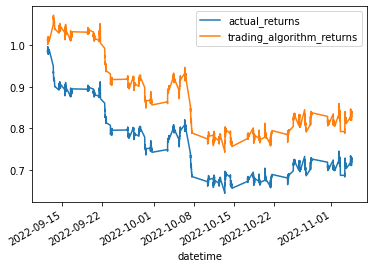

In [26]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---

# Add a New Machine Learning Model

## Import the `LogisticRegression` model from scikit-learn.


In [27]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

In [28]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()


## Using the same training data that the SVM model used (`X_train_scaled` and `y_train`), fit the `LogisticRegression` model.

In [29]:
# Fit the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)


LogisticRegression()

## Use the trained model to predict the trading signals for the training data. Use the `classification_report` module to evaluate the model.

In [30]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions =  logistic_regression_model.predict(X_train_scaled)

# Display the predictions
lr_training_signal_predictions


array([-1., -1., -1., ..., -1., -1., -1.])

In [31]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)


              precision    recall  f1-score   support

        -1.0       0.51      0.55      0.53       843
         1.0       0.51      0.47      0.49       837

    accuracy                           0.51      1680
   macro avg       0.51      0.51      0.51      1680
weighted avg       0.51      0.51      0.51      1680



## Backtest the `LogisticRegression` model using the testing data to evaluate its performance.

In [32]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [33]:
# Generate a classification report using the testing data and the logistic regression model's predications
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the testing classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.50      0.97      0.66      1580
         1.0       0.42      0.02      0.05      1540

    accuracy                           0.50      3120
   macro avg       0.46      0.50      0.35      3120
weighted avg       0.46      0.50      0.36      3120



## Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data. 

In [34]:
# Print the classification report for the SVM model using the test data
print("Logistic Regression Classification Report")
print(lr_testing_report)


Logistic Regression Classification Report
              precision    recall  f1-score   support

        -1.0       0.50      0.97      0.66      1580
         1.0       0.42      0.02      0.05      1540

    accuracy                           0.50      3120
   macro avg       0.46      0.50      0.35      3120
weighted avg       0.46      0.50      0.36      3120



In [35]:
# Print the classification report for the SVM model using the test data
print("SVM Classification Report")
print(svm_testing_report)


SVM Classification Report
              precision    recall  f1-score   support

        -1.0       0.56      0.03      0.06      1580
         1.0       0.50      0.97      0.66      1540

    accuracy                           0.50      3120
   macro avg       0.53      0.50      0.36      3120
weighted avg       0.53      0.50      0.35      3120



### Answer the following question:

**Question:** Did the `LogisticRegression` perform better than the `SVM`?

**Answer:** Maybe. The logistic regression model performs a bit better than the SVM model since it has a higher accuracy score. However, the SVM model does a better job predicting profitable short opportunities, as evidenced by its higher recall score on the -1.0 class. Ultimately, which model is best may depend on which class we care most about predicting, as well as which has better overall economic returns compared to a long-only investment.